# System Identification

System identification is the process of finding a transfer function that predicts outputs
that are close to those predicted by experimental data. These data
may be obtained from actual experiments for from a detailed nonlinear model.
System identification involves: iteratively choosing the size of the numerator and denominator polynomial
of the transfer function,
estimating the parameters of the transfer function, and evaluating the quality of the fit to
the predictions of the transfer function.

## Preliminaries

In [1]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.0.11'

## Models

### LINEAR_MODEL

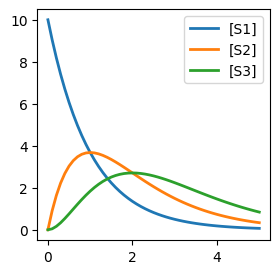

In [2]:
LINEAR_MODEL = """
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 1
k3 = 1
"""
rr = te.loada(LINEAR_MODEL)
rr.simulate()
rr.plot(figsize=(3,3))

In [3]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MODEL, input_names=["S1"], output_names=["S3"])

### WOLF_MODEL

In [4]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
WOLF_MODEL = rr.getAntimony()
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_names=["at_"], output_names=["s5"])
print(WOLF_MODEL)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

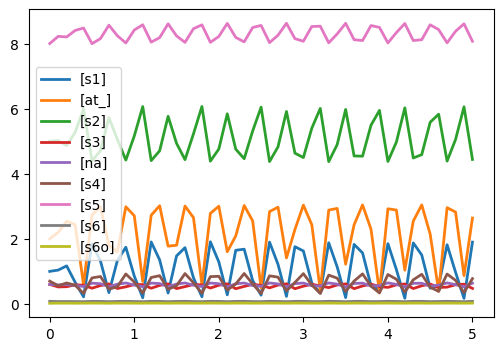

In [5]:
rr = te.loada(WOLF_MODEL)
rr.simulate()
rr.plot()

### MTOR_MODEL

In [6]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
rr = te.loadSBMLModel(MTOR_URL)
MTOR_MODEL = rr.getAntimony()
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_names=["DEPTOR"], output_names=["mTORC1"])
print(MTOR_MODEL)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

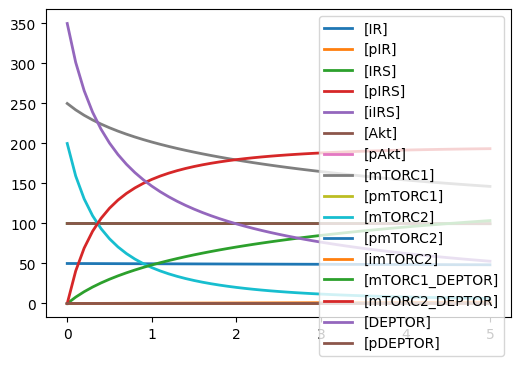

In [7]:
rr = te.loada(MTOR_MODEL)
rr.simulate()
rr.plot()

# Linear model transfer function

In this section, we use LINEAR_MODEL to illustrate system identification.
The work can be simplied by making use of the ``SISOTransferFunctionBuilder``
object in ``ControlSBML``.

## Step 1. Construct the ``SISOTransferFunctionBuilder``

``SISOTransferFunctonBuilder`` is a ``controlSBML`` object that faciliates system identification
of transfer functions for SBML models.

In [8]:
LINEAR_BUILDER = LINEAR_CTLSB.makeSISOTransferFunctionBuilder()
LINEAR_BUILDER.input_name, LINEAR_BUILDER.output_name

('S1', 'S3')

## Step 2. Determine the operating region

The operating region is the range of control inputs that should handled by the controller.
We want to see how responsive the system is to the possible outputs from the controller.
We assess the operating region by using a *staircase input*.
This is a sequence of steps of the same height that have a duration that is sufficiently
long so that the system stabilizes.

In [9]:
STAIRCASE = ctl.Staircase(initial_value=2, final_value=10, num_step=5)

In [10]:
response_ts = LINEAR_BUILDER.makeStaircaseResponse(end_time=100, staircase=STAIRCASE)
response_ts

,S3,S1_staircase
miliseconds,,
0,0.000000,2.0
100,0.045551,2.0
200,0.166018,2.0
300,0.340564,2.0
400,0.552061,2.0
...,...,...
99600,9.995577,10.0
99700,9.995058,10.0
99800,9.994765,10.0


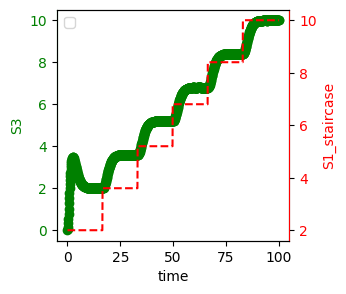

In [11]:
LINEAR_BUILDER.plotStaircaseResponse(response_ts, figsize=(3,3), legend_crd=(0.5, 1), start_time=25, end_time=100)

## Step 3. Find the transfer function

To fit a transfer function, we must specify the number of terms in the
numerator and denominator polynomials for the transfer function.

In [12]:
fitter_result = LINEAR_BUILDER.fitTransferFunction(num_numerator=1, num_denominator=2, staircase=STAIRCASE, start_time=0, end_time=100)


**Observations**
1. Is this the correct response? The response seems much faster than what would be expected from the dominant pole. Have a bug with times. Doing ms simulation?

In [13]:
# Here is the transfer function
fitter_result.transfer_function

TransferFunction(array([0.00969002]), array([0.01548718, 0.0098205 ]))

In [14]:
# The number of function evaluations and the reduced ChiSq are larger because of the initial conditions.
fitter_result.nfev, fitter_result.redchi

(84, 0.1376240551103886)

In [15]:
# The number of function evaluations and the reduced ChiSq are smaller now.
# Also, the fit is much better.
fitter_result.nfev, fitter_result.redchi

(84, 0.1376240551103886)

This plot displays values of ``S3`` in response to values of ``S1``.
We see that the output closely follows the input, and that there is a response over
the entire range of input.

In [16]:
# The transfer function is the same, but it fits better because we eliminated initial conditions.
fitter_result.transfer_function

TransferFunction(array([0.00969002]), array([0.01548718, 0.0098205 ]))

In [17]:
tf = fitter_result.transfer_function
tf.dcgain()

0.9867133041461906

In [18]:
tf.poles()

array([-0.63410543+0.j])

In [19]:
fitter_result.nfev

84

## Step 4. Analyze the fit result

``fitter_result`` has many useful properties.
* ``minimizer_result`` contains detailed information about the results of the optimization
* ``nfev`` is the number of different transfer functions that were evaluated to find the fit
* ``parameters`` contains the parameter values
* ``redchi`` is the reduced ChiSq for the fit
* ``stderr`` contains the standard deviations of the parameter values
* ``time_series`` is a ``Timeseries`` object with the input, nonlinear simulated output, and predicted value of the output
* ``transfer_function`` is the fitted transfer function

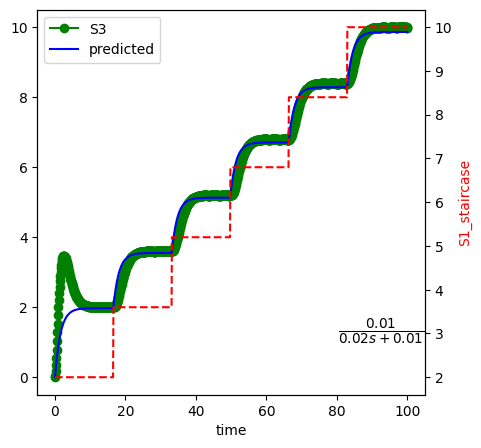

In [20]:
LINEAR_BUILDER.plotFitTransferFunction(fitter_result, figsize=(5,5))

In [21]:
fitter_result.parameters

name,value,standard error,relative error,initial value,min,max,vary
n0,0.00969002,56.5984629,(584090.22%),0.1,-10.0000000,10.0000000,True
d0,0.01548718,90.4573224,(584078.85%),0.1,-10.0000000,10.0000000,True
d1,0.00982050,57.3611778,(584096.15%),0.1,-10.0000000,10.0000000,True


In [22]:
fitter_result.transfer_function

TransferFunction(array([0.00969002]), array([0.01548718, 0.0098205 ]))

#  Wolf Transfer Function

In [57]:
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_names=["at_"], output_names=["s5"])
WOLF_BUILDER = WOLF_CTLSB.makeSISOTransferFunctionBuilder(is_fixed_input_species=False)
WOLF_BUILDER.input_name, WOLF_BUILDER.output_name

('at_', 's5')

In [65]:
WOLF_STAIRCASE = ctl.Staircase(initial_value=50, final_value=100, num_step=5)
response_ts = WOLF_BUILDER.makeStaircaseResponse(staircase=WOLF_STAIRCASE, figsize=(1,2), legend_crd=(0.5, 1), end_time=20)

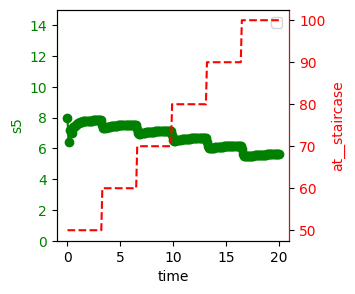

In [66]:
WOLF_BUILDER.plotStaircaseResponse(response_ts, figsize=(3,3), legend_crd=(0.5, 1), ylim=[0, 15])

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Could not find a steady state. Using current state.



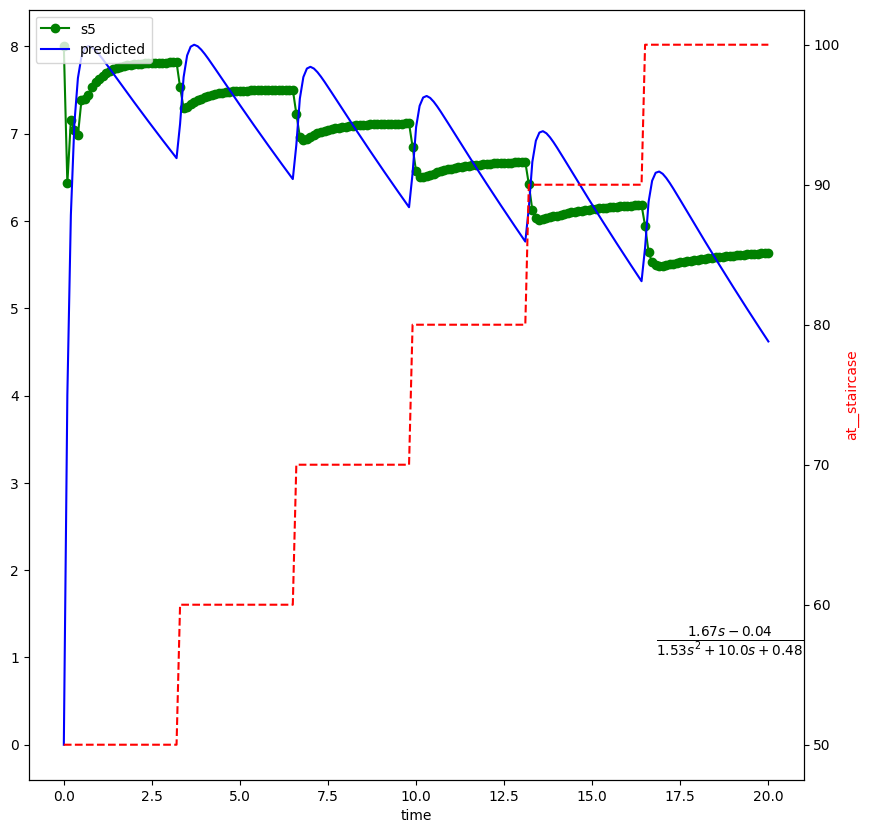

In [68]:
fitter_result = WOLF_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, staircase=WOLF_STAIRCASE, end_time=20)
WOLF_BUILDER.plotFitTransferFunction(fitter_result)

In [69]:
fitter_result.transfer_function

TransferFunction(array([ 1.67077104, -0.03848503]), array([1.52769016, 9.99999944, 0.47768611]))

In [70]:
fitter_result.transfer_function.dcgain()

-0.08056552404386391

# mTOR transfer function

In [83]:
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_names=["k15c"], output_names=["IRS"])
MTOR_BUILDER = MTOR_CTLSB.makeSISOTransferFunctionBuilder(is_fixed_input_species=True)
MTOR_STAIRCASE = ctl.Staircase(initial_value=0, final_value=0.1, num_step=1)
response_ts = MTOR_BUILDER.makeStaircaseResponse(staircase=MTOR_STAIRCASE, end_time=3000)

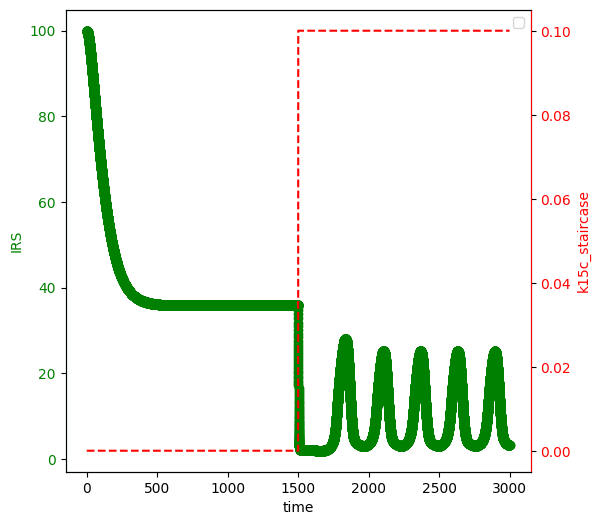

In [84]:
MTOR_BUILDER.plotStaircaseResponse(response_ts,  figsize=(6,6), legend_crd=(2, 1))

DEPTOR has an inhibitory effect on mTORC1, swithcing it of when DEPTOR is high.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Possible numerical instability: max abs residual is 100.000000



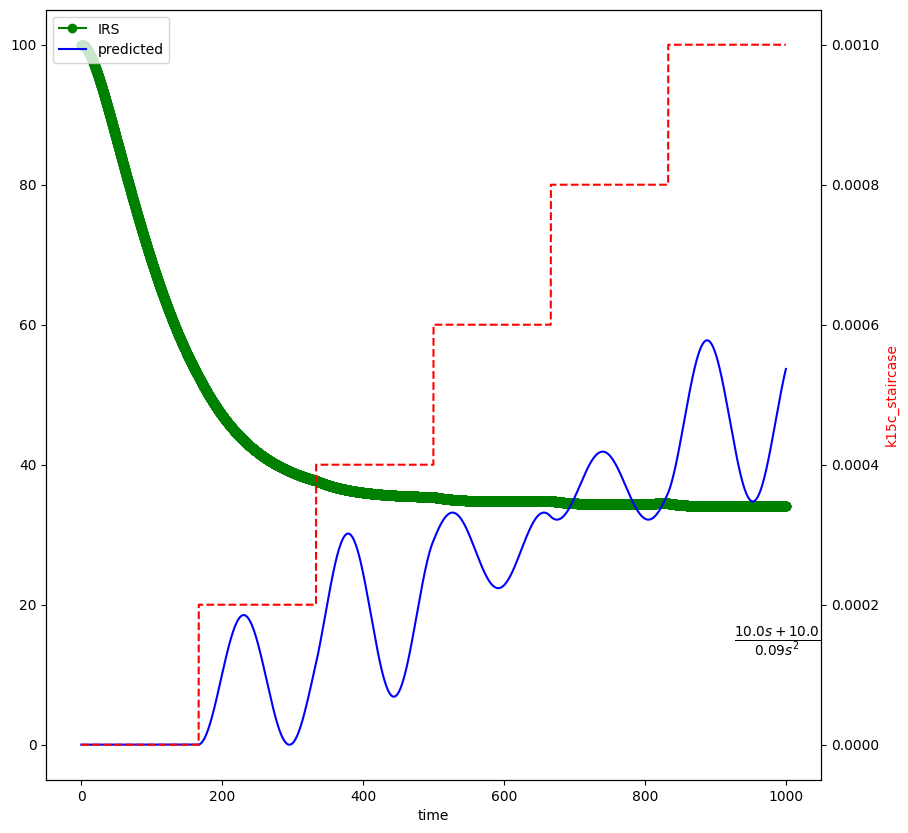

In [30]:
staircase = ctl.Staircase(initial_value=0, final_value=0.001, num_step=5)
fitter_result = MTOR_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, staircase=staircase, start_time=0, end_time=1000)
MTOR_BUILDER.plotFitTransferFunction(fitter_result)

There does not seem to be a relationship between the step input and the output.

# Metformin in Mice (MODEL2206230001)

This is a whole-body model representing the pharmacokinetics of metformin in the mouse body. The model is in the form of ordinary differential equations and describes metformin concentration in 20 compartments. The model consists of 20 compartments (“Compartments” in COPASI model) describing various tissues or tissue sub-compartments and body fluids of metformin action (venous and arterial plasma, intestine, kidney, heart, fat, muscle, brain, lungs, stomach, liver, portal vein, remainder urine and feces).

In [31]:
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
ctlsb = ctl.ControlSBML(url, input_names=["mHeart"], output_names=["mMuscle"])
print(ctlsb.antimony)
METFORMIN_BUILDER = ctlsb.makeSISOTransferFunctionBuilder(is_fixed_input_species=True)

// Created by libAntimony v2.13.2
function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function Glomerular(S, Flow)
  S*Flow;
end

Glomerular is "Glomerular"

function Flow(Q, S)
  Q*S;
end

Flow is "Flow"

function Flow_from_organ(Q, S, Ktp)
  Q*S/Ktp;
end

Flow_from_organ is "Flow from organ"


model *Zake2021___PBPK_model_of_metformin_in_mice__single_dose_intavenous()

  // Compartments and Species:
  compartment IntestineLumen, Liver, KidneyPlasma, Remainder, PlasmaVenous;
  compartment Urine, Feces, Heart, Muscle, Brain, Adipose, PlasmaArterial;
  compartment Lung, PortalVein, Stomach, IntestineEnterocytes, KidneyTissue;
  compartment IntestineVascular, StomachLumen, KidneyTubular;
  substanceOnly species mLiver in Liver, mKidneyPlasma in KidneyPlasma, mRemainder in Remainder;
  substanceOnly species mPlasmaVenous in PlasmaVenous, mHeart in Heart, mMuscl

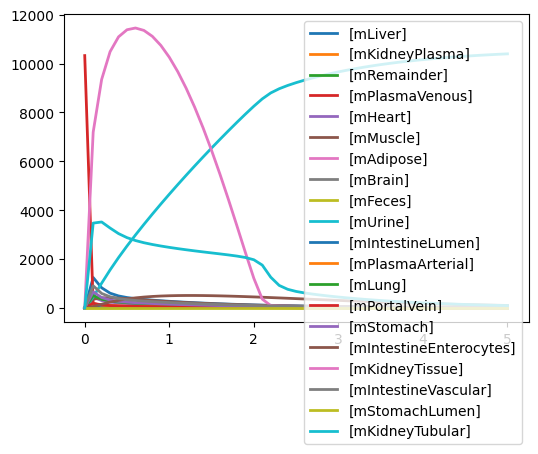

In [32]:
ctlsb.roadrunner.simulate()
ctlsb.roadrunner.plot()

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Could not find a steady state. Using current state.



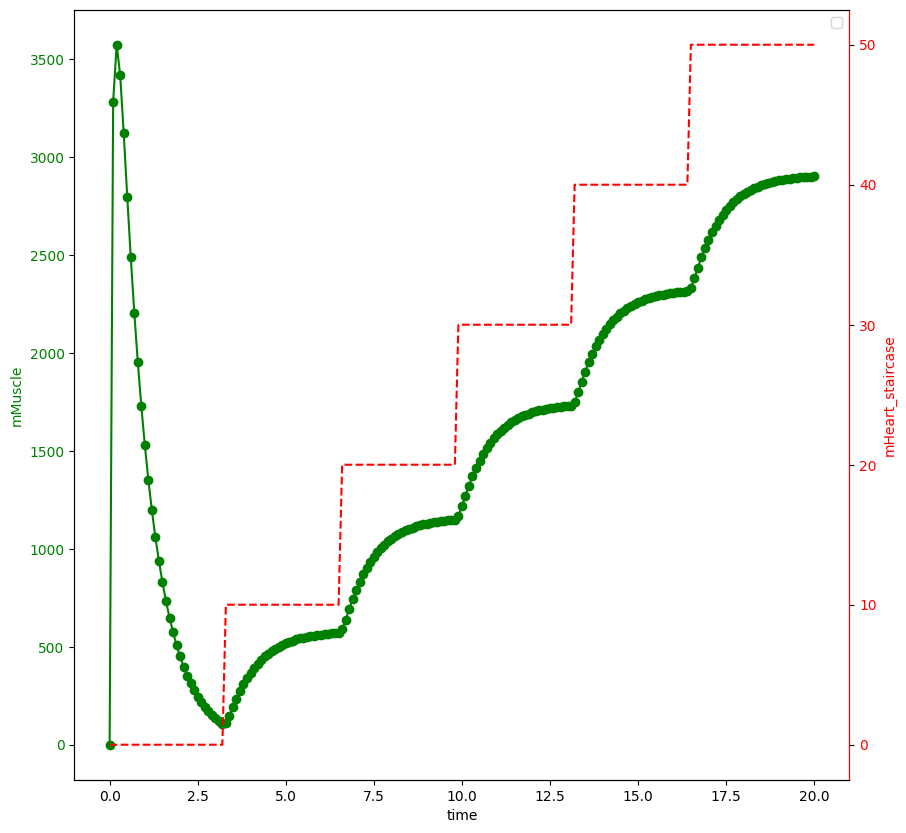

In [33]:
METFORMIN_STAIRCASE = ctl.Staircase(initial_value=0, final_value=50, num_step=5)
response_ts = METFORMIN_BUILDER.makeStaircaseResponse(staircase=METFORMIN_STAIRCASE, end_time=20)
METFORMIN_BUILDER.plotStaircaseResponse(response_ts)

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Could not find a steady state. Using current state.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Possible numerical instability: max abs residual is 76.263073



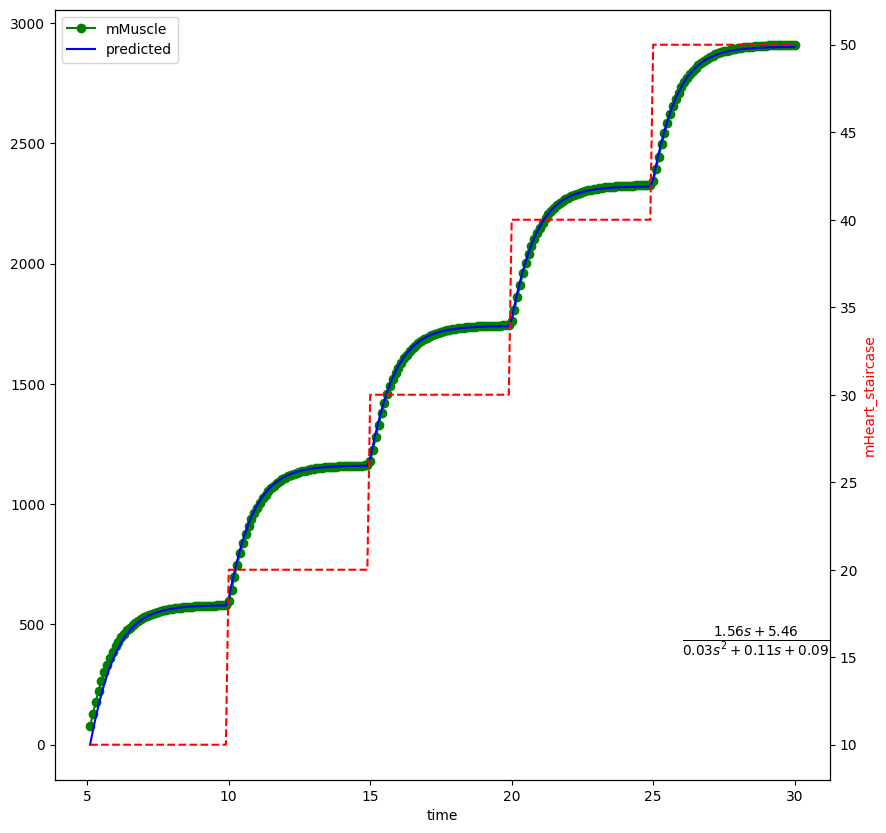

In [85]:
fitter_result = METFORMIN_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, 
                                                      staircase=METFORMIN_STAIRCASE, fit_start_time=5, start_time=0, end_time=30)
METFORMIN_BUILDER.plotFitTransferFunction(fitter_result)

In [86]:
fitter_result.transfer_function.dcgain()*50

2902.4784058115238

In [88]:
fitter_result.redchi

166.11475367767738

In [89]:
fitter_result.nfev

218

In [90]:
fitter_result.stderr

{'n0': 2478.2838437625774,
 'n1': 8653.211746563213,
 'd0': 40.87824761094794,
 'd1': 166.61996907358522,
 'd2': 149.00940305984426}

In [91]:
fitter_result.transfer_function

TransferFunction(array([1.56430202, 5.46450078]), array([0.02580499, 0.10524022, 0.09413508]))

In [92]:
fitter_result.transfer_function.poles()

array([-2.75340714+0.j, -1.32488258+0.j])